In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/Final_dataset.csv", on_bad_lines='skip', engine='python')
#on_bad= skip the malformed rows in csv
#engine= use python engine for parsingg since it is more robust

In [4]:
data=df[['statement','status']]
display(data.head(20))

,statement,status
0,"['oh', 'my', 'gosh']",Anxiety
1,"['trouble', 'sleep', 'confused', 'mind', 'rest...",Anxiety
2,"['all', 'wrong', 'back', 'off', 'dear', 'forwa...",Anxiety
3,"['I', 've', 'shift', 'my', 'focus', 'to', 'som...",Anxiety
4,"['I', 'm', 'restless', 'and', 'restless', 'its...",Anxiety
5,"['every', 'break', 'you', 'must', 'be', 'nervo...",Anxiety
6,"['I', 'feel', 'scared', 'anxious', 'what', 'ca...",Anxiety
7,"['have', 'you', 'ever', 'feel', 'nervous', 'bu...",Anxiety
8,"['I', 'have', 'not', 'sleep', 'well', 'for', '...",Anxiety
9,"['I', 'm', 'really', 'worried', 'I', 'want', '...",Anxiety


In [5]:
data.status.value_counts()
#count frequency of each label category

,count
status,
Normal,16020
Depression,15086
Suicidal,10641
Anxiety,3613
Bipolar,2501
Stress,2293
Personality disorder,895


In [6]:
from sklearn.utils import resample
import pandas as pd

# Step 1: Optional - sample a subset if dataset is large
df_sample = df.sample(n=min(30000, len(df)), random_state=42)

# Step 2: Determine the target size for resampling
class_counts = df_sample['status'].value_counts()
majority_size = class_counts.max()  # Automatically pick the largest class
print(f"Target size for all classes: {majority_size}")

# Step 3: Resampling function
def resample_class(df_subset, target_size):
    """
    Resample a dataframe subset to the target size.
    Oversample if smaller, undersample if larger.
    """
    if len(df_subset) == 0:
        return df_subset
    if len(df_subset) >= target_size:
        # Undersample
        return df_subset.sample(n=target_size, random_state=42, replace=False)
    else:
        # Oversample
        return resample(df_subset, replace=True, n_samples=target_size, random_state=42)

# Step 4: Apply resampling to all classes
resampled_dfs = []
for status_val in class_counts.index:
    df_class = df_sample[df_sample['status'] == status_val]
    resampled_df = resample_class(df_class, majority_size)
    print(f"Status {status_val}: Original {len(df_class)} → Resampled {len(resampled_df)}")
    resampled_dfs.append(resampled_df)

# Step 5: Combine resampled data
df_balanced = pd.concat(resampled_dfs, axis=0).reset_index(drop=True)

# Step 6: Keep only relevant columns
data = df_balanced[['statement', 'status']]

# Step 7: Check new distribution
print("\nAfter resampling class distribution:")
print(data['status'].value_counts())
print(f"\nTotal samples: {len(data)}")


Target size for all classes: 9489
Status Normal: Original 9489 → Resampled 9489
Status Depression: Original 8860 → Resampled 9489
Status Suicidal: Original 6165 → Resampled 9489
Status Anxiety: Original 2126 → Resampled 9489
Status Bipolar: Original 1499 → Resampled 9489
Status Stress: Original 1323 → Resampled 9489
Status Personality disorder: Original 538 → Resampled 9489

After resampling class distribution:
status
Normal                  9489
Depression              9489
Suicidal                9489
Anxiety                 9489
Bipolar                 9489
Stress                  9489
Personality disorder    9489
Name: count, dtype: int64

Total samples: 66423


In [7]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['status_encoded'] = label_encoder.fit_transform(data['status'])
#labelencoder=converts the categorical text labels to numerical values
#fit_transform=learns the mapping and apply it in one step
#create a new column with the status encoded

In [8]:
X = data['statement']
y = data['status_encoded']

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train size: {len(X_train)}")
print(f"Val size:   {len(X_val)}")
print(f"Test size:  {len(X_test)}")

#stratify= always have the same percentage in classes in train and test

Train size: 53138
Val size:   6642
Test size:  6643


FastText is a word embedding technique developed by Facebook AI Research. Unlike traditional word2vec, FastText represents each word as a bag of character n-grams, which helps it understand:

Subword information (prefixes, suffixes, roots)

Morphological variations (running, runs, ran)

Misspelled words

Rare/out-of-vocabulary words


In [10]:
!pip install gensim

from gensim.models import FastText
import numpy as np


sentences = [sentence.split() for sentence in X_train]
#split sentences to words


ft_model = FastText(sentences, vector_size=100, window=5, min_count=5, workers=4, sg=1)
#vector_size= each word is represented as 100D vector that has semantic features
#< 50 dimensions: Too few, can't capture enough semantics
# 50-100 dimensions: Good balance for most tasks
# 100-300 dimensions: Better for complex semantic relationships
#window= model learns from words within 5 positions before and after
#min_count=gnores words appearing less than 5 times in the dataset
#Prevents rare/misspelled words from cluttering the vocabulary
#skip_fram Predict context from target word	Predict target from context words
#Better for rare words
#1. "Better for rare words"        # Your dataset might have rare sentiment words
#2. "Better semantic relationships"


def vectorize(sentence):
    words = sentence.split()
    words_vecs = [ft_model.wv[word] for word in words]
    #get the wordvector of each word and put them in a an array
   # the dimentions is (n, 100) n= number of words
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)
    #average them to create one sentence vector

X_train_vec = np.array([vectorize(sentence) for sentence in X_train])
X_test_vec = np.array([vectorize(sentence) for sentence in X_test])
X_val_vec = np.array([vectorize(sentence) for sentence in X_val])



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 91.6 MB/s eta 0:00:00


In [20]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score



In [21]:
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [22]:
train_dataset = SentimentDataset(X_train_vec, y_train)
test_dataset = SentimentDataset(X_test_vec, y_test)
val_dataset = SentimentDataset(X_val_vec, y_val)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [23]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # add sequence dimension
        out, h_n = self.rnn(x)
        out = self.fc(h_n.squeeze(0))  # use last hidden state
        return out


In [24]:
input_size = X_train_vec.shape[1]
hidden_size = 500
num_classes = len(label_encoder.classes_)

model = RNNClassifier(input_size, hidden_size, num_classes)


In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs =100

In [26]:
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            running_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    avg_loss = running_loss / len(loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy


train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    val_loss, val_acc = evaluate(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(
      f"Epoch {epoch+1}/{num_epochs} | "
      f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
      f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )



Epoch 1/100 | Train Loss: 1.1294, Train Acc: 0.6003 | Val Loss: 0.9936, Val Acc: 0.6530
Epoch 2/100 | Train Loss: 0.9894, Train Acc: 0.6536 | Val Loss: 1.0220, Val Acc: 0.6253
Epoch 3/100 | Train Loss: 0.9752, Train Acc: 0.6595 | Val Loss: 0.9717, Val Acc: 0.6590
Epoch 4/100 | Train Loss: 0.9652, Train Acc: 0.6628 | Val Loss: 0.9739, Val Acc: 0.6606
Epoch 5/100 | Train Loss: 0.9585, Train Acc: 0.6620 | Val Loss: 0.9586, Val Acc: 0.6579
Epoch 6/100 | Train Loss: 0.9490, Train Acc: 0.6662 | Val Loss: 0.9671, Val Acc: 0.6608
Epoch 7/100 | Train Loss: 0.9425, Train Acc: 0.6648 | Val Loss: 0.9414, Val Acc: 0.6597
Epoch 8/100 | Train Loss: 0.9331, Train Acc: 0.6694 | Val Loss: 0.9216, Val Acc: 0.6749
Epoch 9/100 | Train Loss: 0.9279, Train Acc: 0.6714 | Val Loss: 0.9275, Val Acc: 0.6682
Epoch 10/100 | Train Loss: 0.9188, Train Acc: 0.6720 | Val Loss: 0.9150, Val Acc: 0.6707
Epoch 11/100 | Train Loss: 0.9137, Train Acc: 0.6759 | Val Loss: 0.9285, Val Acc: 0.6737
Epoch 12/100 | Train Loss: 0.9

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

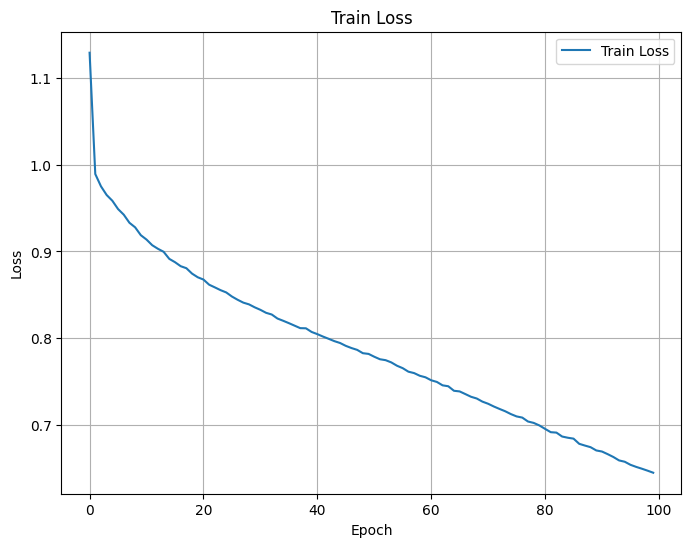

In [28]:

plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss")
plt.legend()
plt.grid(True)
plt.show()


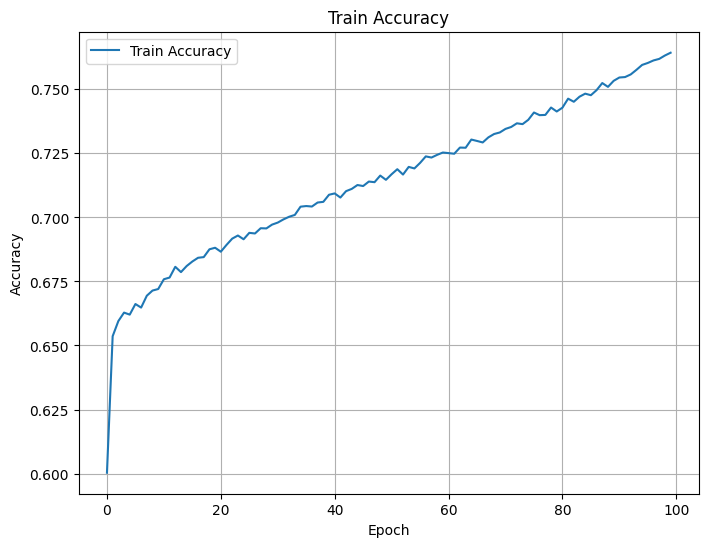

In [29]:

plt.figure(figsize=(8,6))
plt.plot(train_accuracies, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train Accuracy")
plt.legend()
plt.grid(True)
plt.show()



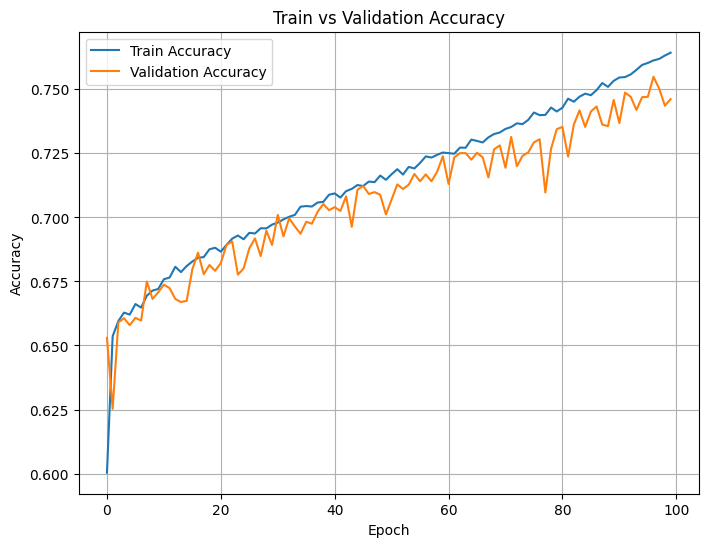

In [31]:
plt.figure(figsize=(8,6))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()



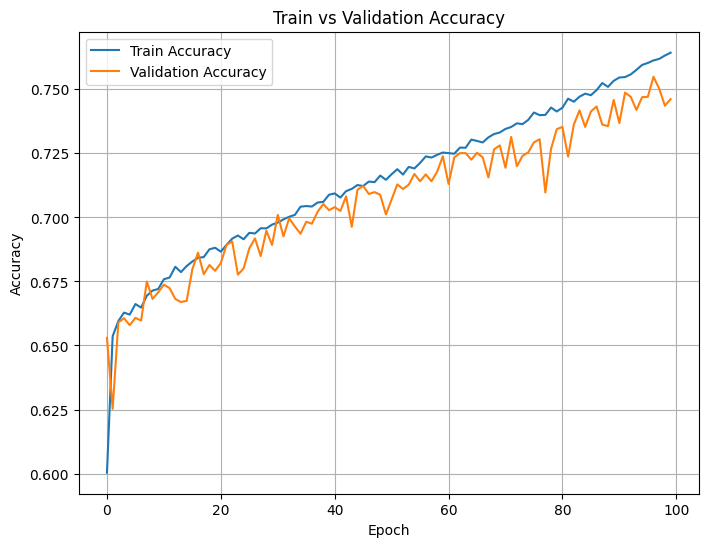

In [33]:
plt.figure(figsize=(8,6))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()



In [35]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(y_batch.numpy())

print("Test Accuracy:", accuracy_score(all_labels, all_preds))
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=label_encoder.classes_))



Test Accuracy: 0.7436399217221135

Classification Report:
                       precision    recall  f1-score   support

             Anxiety       0.88      0.80      0.84       949
             Bipolar       0.81      0.80      0.80       949
          Depression       0.57      0.46      0.51       949
              Normal       0.87      0.87      0.87       949
Personality disorder       0.89      0.78      0.83       949
              Stress       0.59      0.82      0.68       949
            Suicidal       0.67      0.68      0.67       949

            accuracy                           0.74      6643
           macro avg       0.75      0.74      0.74      6643
        weighted avg       0.75      0.74      0.74      6643



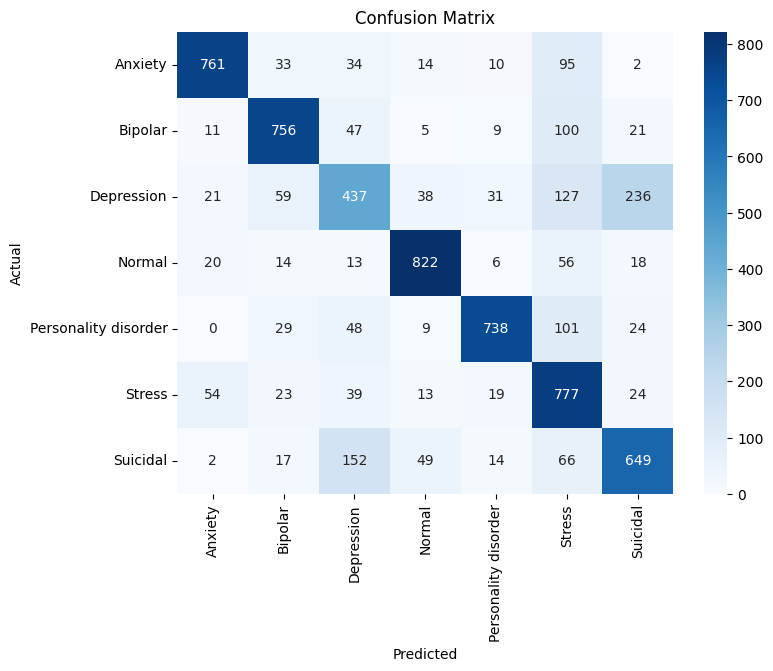

In [36]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()